# Regression of song year
Another example of real-world data. Here we want to try and predict which years in which songs were released.

The data are discussed in https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
We have a range of songs from different years, and the features are based on the timbre of the music. The aim is to build a model based on the timbre features to regress to the year of release

Run the cell below to download the data

In [ ]:
!mkdir ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip -O ./data/YearPredictionMSD.txt.zip
!unzip ./data/YearPredictionMSD.txt.zip

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from collections import OrderedDict, defaultdict, deque
import os
import math
from pathlib2 import Path

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from typing import *
from fastprogress import progress_bar

import torch
from torch import nn, Tensor, optim
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCELoss, MSELoss

# Data Importing
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [3]:
df = pd.read_csv('data/YearPredictionMSD.txt', header=None); print(len(df)); df.head()

515345


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [4]:
df.columns = ["Target"]+[f'Feat_{i}' for i in range(90)]

In [5]:
df.head()

,Target,Feat_0,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,...,Feat_80,Feat_81,Feat_82,Feat_83,Feat_84,Feat_85,Feat_86,Feat_87,Feat_88,Feat_89
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


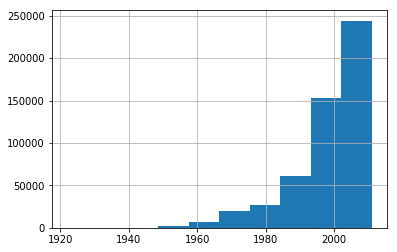

In [6]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

For this dataset, a specific split is recommended to avoid the same producer being in both training and validation, which could allow the model to cheat by recognising producers.

In [7]:
df_train,df_val = df[:463715],df[463715:]

In [8]:
len(df_val)

51630

# Your solution